<a href="https://colab.research.google.com/github/ThokozileKhosa/COS801_Project/blob/main/COS801_CNN_IMPLEMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
### General Imports ###
import os
import cv2
import numpy as np

### Image Processing imports ###
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

### Model training imports ###
from tqdm import tqdm
import torch
from pprint import pprint
import torch.optim as optim
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision.models.resnet import BasicBlock
from sklearn.metrics import classification_report, accuracy_score

## Data Preprocessing

In [3]:
def extract_frames_from_video(video_path, output_dir, frame_size=(112, 112)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frames = []
    success, frame = cap.read()
    while success:
        # Resize to 112x112 for C3D model
        frame = cv2.resize(frame, frame_size)
        frames.append(frame)
        success, frame = cap.read()
    cap.release()

    # Save frames to output directory
    for i, frame in enumerate(frames):
        cv2.imwrite(os.path.join(output_dir, f"frame_{i:04d}.png"), frame)

    return len(frames)

def create_clips_from_frames(frames_dir, clip_size=16):
  frame_paths = sorted(glob(os.path.join(frames_dir, "*.png")))
  clips = []
  total_frames = len(frame_paths)

  # Split frames into clips with padding (ensure even sizes)
  for i in range(0, total_frames, clip_size):
      clip_frames = frame_paths[i:i + clip_size]

      if len(clip_frames) < clip_size:
          clip_frames += [clip_frames[-1]] * (clip_size - len(clip_frames))
      clips.append(clip_frames)
  return clips


def prepare_data_for_training(video_paths, label, clip_size=16):

    # Compile training & testing data with labels
    data = []
    labels = []

    for video_path in tqdm(video_paths):
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        frames_dir = f"/content/frames/{video_name}"

        # Extract frames from video and create clips
        extract_frames_from_video(video_path, frames_dir)
        clips = create_clips_from_frames(frames_dir, clip_size=clip_size)

        for clip in clips:
            data.append(clip)
            labels.append(label)
    return data, labels

In [4]:
# Deleted frames folder for reruns
#!ls
#!rm -rf frames

In [5]:
# Path to videos saved locally
normal_videos = glob('/content/drive/MyDrive/CSC 801/Project/Data_1/Normal_Abnormal_Crowd/Normal Crowds/*')
abnormal_videos = glob('/content/drive/MyDrive/CSC 801/Project/Data_1/Normal_Abnormal_Crowd/Abnormal Crowds/*')

# Video Preprocessing
normal_data, normal_labels = prepare_data_for_training(normal_videos, label=0, clip_size=16)
abnormal_data, abnormal_labels = prepare_data_for_training(abnormal_videos, label=1, clip_size=16)

# Balance normal (truncate) and abnoraml data distribution
num_normal_samples = len(normal_data)
reduced_normal_data_indices = np.random.choice(num_normal_samples, num_normal_samples // 3, replace=False)

normal_data = [normal_data[i] for i in reduced_normal_data_indices]
normal_labels = [normal_labels[i] for i in reduced_normal_data_indices]

# Combine into full dataset and split into training and testing
full_dataset = normal_data + abnormal_data
full_labels = normal_labels + abnormal_labels

train_data, test_data, train_labels, test_labels = train_test_split(full_dataset, full_labels, test_size=0.3, random_state=42)

100%|██████████| 9/9 [00:17<00:00,  1.94s/it]


In [6]:
len(normal_data), len(abnormal_data)

(198, 163)

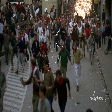

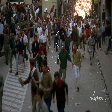

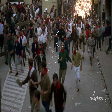

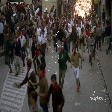

In [7]:
def sample_frames(frames_dir, num_frames=4):
    # Show sample clips generated
    frame_paths = sorted(glob(os.path.join(frames_dir, "*.png")))

    # Select the first 4 frames
    sample_paths = frame_paths[:num_frames]

    # Read and show sample images
    for i, frame_path in enumerate(sample_paths):
        frame = cv2.imread(frame_path)
        cv2_imshow(frame)
        #cv2.waitKey(0)
    #cv2.destroyAllWindows()

# Select random generated frame directory (abnornal crowd sample)
frames_dir = "/content/frames/263C044_060_c"
sample_frames(frames_dir, num_frames=4)

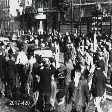

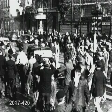

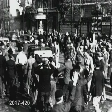

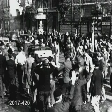

In [8]:
# Select random generated frame directory (abnornal crowd sample)
frames_dir = "/content/frames/2017-420_l"
sample_frames(frames_dir, num_frames=4)

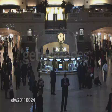

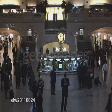

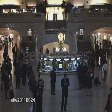

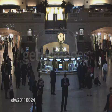

In [9]:
# Select random generated frame directory (nornal crowd sample)
frames_dir = "/content/frames/sfw20110024_l"
sample_frames(frames_dir, num_frames=4)

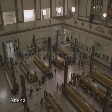

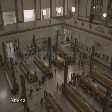

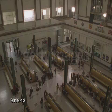

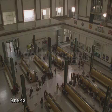

In [10]:
# Select random generated frame directory (nornal crowd sample)
frames_dir = "/content/frames/9019-13_l"
sample_frames(frames_dir, num_frames=4)

In [11]:
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    # Format image clips into model format (normalise, stack images, create batches)
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        clip_frames = self.data[idx]
        label = self.labels[idx]

        # Load frames and stack them
        clip = [cv2.imread(frame) for frame in clip_frames]
        # Shape: (clip_size, H, W, C)
        clip = np.stack(clip, axis=0)
        # Convert shape to (C, clip_size, H, W)
        clip = np.transpose(clip, (3, 0, 1, 2))
        # Normalize pixel intensity to [0, 1]
        clip = torch.tensor(clip, dtype=torch.float32) / 255.0

        return clip, label

# Create data loaders
train_dataset = VideoDataset(train_data, train_labels)
test_dataset = VideoDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

## Load pre-trained C3D model

In [12]:
!git clone https://github.com/DavideA/c3d-pytorch.git

fatal: destination path 'c3d-pytorch' already exists and is not an empty directory.


In [13]:
cd /content/c3d-pytorch/

/content/c3d-pytorch


In [14]:
!wget http://imagelab.ing.unimore.it/files/c3d_pytorch/c3d.pickle
!ls

--2024-11-28 00:46:00--  http://imagelab.ing.unimore.it/files/c3d_pytorch/c3d.pickle
Resolving imagelab.ing.unimore.it (imagelab.ing.unimore.it)... 155.185.48.35
Connecting to imagelab.ing.unimore.it (imagelab.ing.unimore.it)|155.185.48.35|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://aimagelab.ing.unimore.it/files/c3d_pytorch/c3d.pickle [following]
--2024-11-28 00:46:01--  https://aimagelab.ing.unimore.it/files/c3d_pytorch/c3d.pickle
Resolving aimagelab.ing.unimore.it (aimagelab.ing.unimore.it)... 155.185.48.35
Connecting to aimagelab.ing.unimore.it (aimagelab.ing.unimore.it)|155.185.48.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319966434 (305M) [application/octet-stream]
Saving to: ‘c3d.pickle.1’

c3d.pickle.1        100%[===================>] 305.14M  3.46MB/s    in 90s     

2024-11-28 00:47:32 (3.41 MB/s) - ‘c3d.pickle.1’ saved [319966434/319966434]

3dcnn_trained.pth	  C3D_model.py	c3d.pickle.1 

In [15]:
from C3D_model import C3D

# Load pre-trained model
model = C3D()
model.load_state_dict(torch.load('c3d.pickle',weights_only=True))

# Modify output layer for binary classification
model.fc8 = nn.Linear(4096, 2)

# Freeze the pre-trained layers for feature extraction
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final output layer for training
for param in model.fc8.parameters():
    param.requires_grad = True

# Move to GPU (Google Collab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss (origional 3cd model used in multiclass classification - replicating this in the binary application for consistancy) and optimizer
criterion = nn.CrossEntropyLoss()

# Adding L2 regularization (weight_decay) to the optimiser
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Variables to store performance variables
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
data_labels = []
data_predictions = []

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for clips, labels in train_loader:
        clips, labels = clips.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(clips)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get the predicted class index
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and store train loss and accuracy for epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluate on testing dataset
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for clips, labels in test_loader:
            clips, labels = clips.to(device), labels.to(device)
            outputs = model(clips)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get the predicted class index
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store the actual labels and predicted labels (confusion matrix)
            data_labels.extend(labels.cpu().numpy())
            data_predictions.extend(predicted.cpu().numpy())

    # Calculate and store loss and accuracy results for this epoch
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/20], Train Loss: 0.7095, Train Acc: 52.78%, Test Loss: 0.6549, Test Acc: 55.96%
Epoch [2/20], Train Loss: 0.6619, Train Acc: 60.32%, Test Loss: 0.6271, Test Acc: 74.31%
Epoch [3/20], Train Loss: 0.6354, Train Acc: 64.29%, Test Loss: 0.6417, Test Acc: 58.72%
Epoch [4/20], Train Loss: 0.6182, Train Acc: 67.06%, Test Loss: 0.6209, Test Acc: 64.22%
Epoch [5/20], Train Loss: 0.6285, Train Acc: 63.10%, Test Loss: 0.5751, Test Acc: 88.99%
Epoch [6/20], Train Loss: 0.6067, Train Acc: 69.84%, Test Loss: 0.5945, Test Acc: 64.22%
Epoch [7/20], Train Loss: 0.6050, Train Acc: 69.05%, Test Loss: 0.5720, Test Acc: 79.82%
Epoch [8/20], Train Loss: 0.6006, Train Acc: 68.25%, Test Loss: 0.5852, Test Acc: 67.89%
Epoch [9/20], Train Loss: 0.6066, Train Acc: 68.25%, Test Loss: 0.5404, Test Acc: 89.91%
Epoch [10/20], Train Loss: 0.5820, Train Acc: 74.60%, Test Loss: 0.5423, Test Acc: 84.40%
Epoch [11/20], Train Loss: 0.5955, Train Acc: 69.05%, Test Loss: 0.5321, Test Acc: 84.40%
Epoch [12/20], Trai

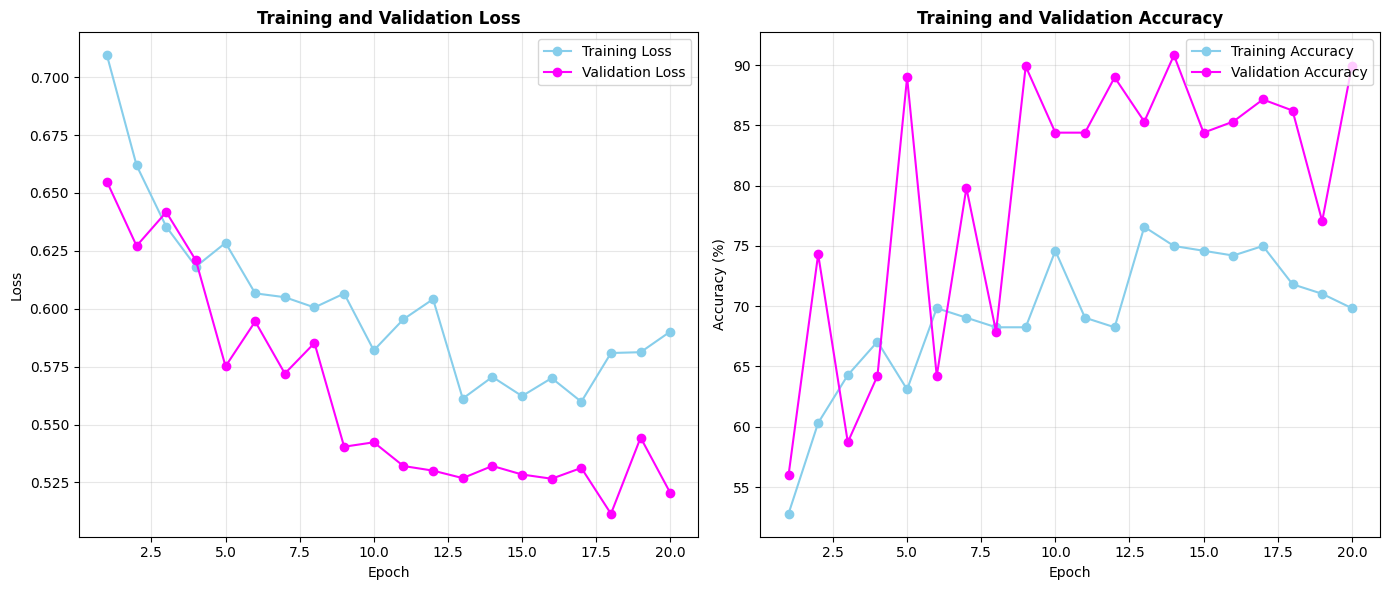

In [16]:
# Plot loss and accuracy curves
plt.figure(figsize=(14, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1),train_losses, label='Training Loss', color='skyblue', marker='o', markersize=6)
plt.plot(range(1, num_epochs + 1),test_losses, label='Validation Loss', color='magenta', marker='o', markersize=6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss', fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1),train_accuracies, label='Training Accuracy', color='skyblue', marker='o', markersize=6)
plt.plot(range(1, num_epochs + 1),test_accuracies, label='Validation Accuracy', color='magenta', marker='o', markersize=6)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy',fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

# Overall layout adjustments
plt.tight_layout()
plt.show()

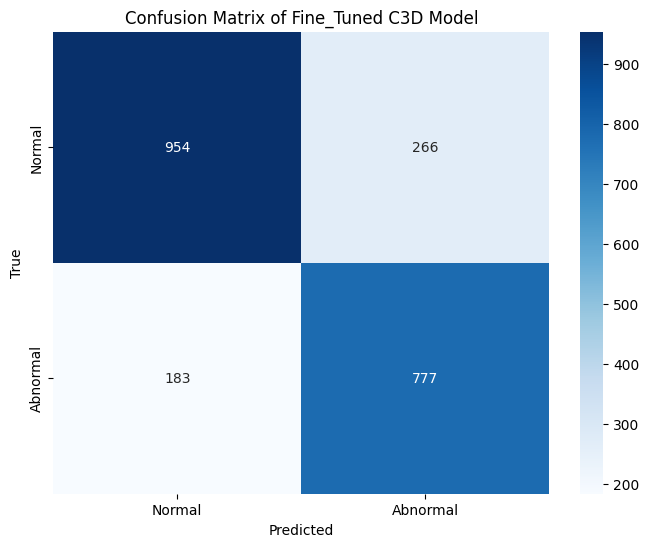

In [17]:
# Compute the confusion matrix
cm = confusion_matrix(data_labels, data_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix of Fine_Tuned C3D Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
accuracy = accuracy_score(data_labels, data_predictions)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn) # Sensitivity
specificity = tn / (tn + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Classification report
report = classification_report(data_labels, data_predictions, target_names=['Normal', 'Abnormal'])
print("\nClassification Report:\n", report)

Accuracy: 0.79
Precision: 0.74
Recall (Sensitivity): 0.81
Specificity: 0.78
F1 Score: 0.78

Classification Report:
               precision    recall  f1-score   support

      Normal       0.84      0.78      0.81      1220
    Abnormal       0.74      0.81      0.78       960

    accuracy                           0.79      2180
   macro avg       0.79      0.80      0.79      2180
weighted avg       0.80      0.79      0.79      2180



## Specially Trained 3DCNN model

In [19]:
# Build and train custom 3D CNN Model for comparison of transfer learning

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()

        # 3D convolutional layers
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)

        # Max Pooling and dropout layers
        self.pool1 = nn.MaxPool3d((2, 2, 2))
        self.pool2 = nn.MaxPool3d((1, 2, 2))
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = None
        # Binary Classification
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Apply ReLU Activation and Pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))

        # Set fc1 dynamically during forward pass
        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(flattened_size, 128).to(x.device)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Sigmoid activation function
        x = torch.sigmoid(self.fc2(x))

        return x

# Initialize model
model = CNN3D().to(device)

# Define loss (Binary Cross-Entropy for binary classification) and optimiser
criterion = nn.BCELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [20]:
# Training loop
num_epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
data_labels = []
data_predictions = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    # Training phase
    for clips, labels in train_loader:
        # Make output labels floats and reshape model outputs to match
        clips, labels = clips.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(clips).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and store train loss and accuracy for epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
      for clips, labels in test_loader:
          clips, labels = clips.to(device), labels.to(device).float()
          outputs = model(clips).view(-1)
          loss = criterion(outputs, labels)

          val_loss += loss.item()
          # Convert to binary predictions
          predicted = (outputs > 0.5).float()
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Store the actual labels and predicted labels (confusion matrix)
          data_labels.extend(labels.cpu().numpy())
          data_predictions.extend(predicted.cpu().numpy())

    # Calculate and store train loss and accuracy for epoch
    avg_val_loss = val_loss / len(test_loader)
    test_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    test_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), '3dcnn_trained.pth')

Epoch [1/20], Train Loss: 0.6634, Train Accuracy: 57.94%, Validation Loss: 0.6398, Validation Accuracy: 85.32%
Epoch [2/20], Train Loss: 0.6119, Train Accuracy: 70.63%, Validation Loss: 0.5576, Validation Accuracy: 64.22%
Epoch [3/20], Train Loss: 0.4884, Train Accuracy: 81.35%, Validation Loss: 0.3757, Validation Accuracy: 88.99%
Epoch [4/20], Train Loss: 0.3559, Train Accuracy: 85.71%, Validation Loss: 0.2841, Validation Accuracy: 93.58%
Epoch [5/20], Train Loss: 0.3511, Train Accuracy: 84.92%, Validation Loss: 0.2221, Validation Accuracy: 93.58%
Epoch [6/20], Train Loss: 0.3179, Train Accuracy: 90.48%, Validation Loss: 0.2109, Validation Accuracy: 95.41%
Epoch [7/20], Train Loss: 0.1939, Train Accuracy: 94.44%, Validation Loss: 0.1651, Validation Accuracy: 89.91%
Epoch [8/20], Train Loss: 0.1692, Train Accuracy: 92.46%, Validation Loss: 0.1807, Validation Accuracy: 91.74%
Epoch [9/20], Train Loss: 0.1864, Train Accuracy: 92.06%, Validation Loss: 0.1315, Validation Accuracy: 97.25%
E

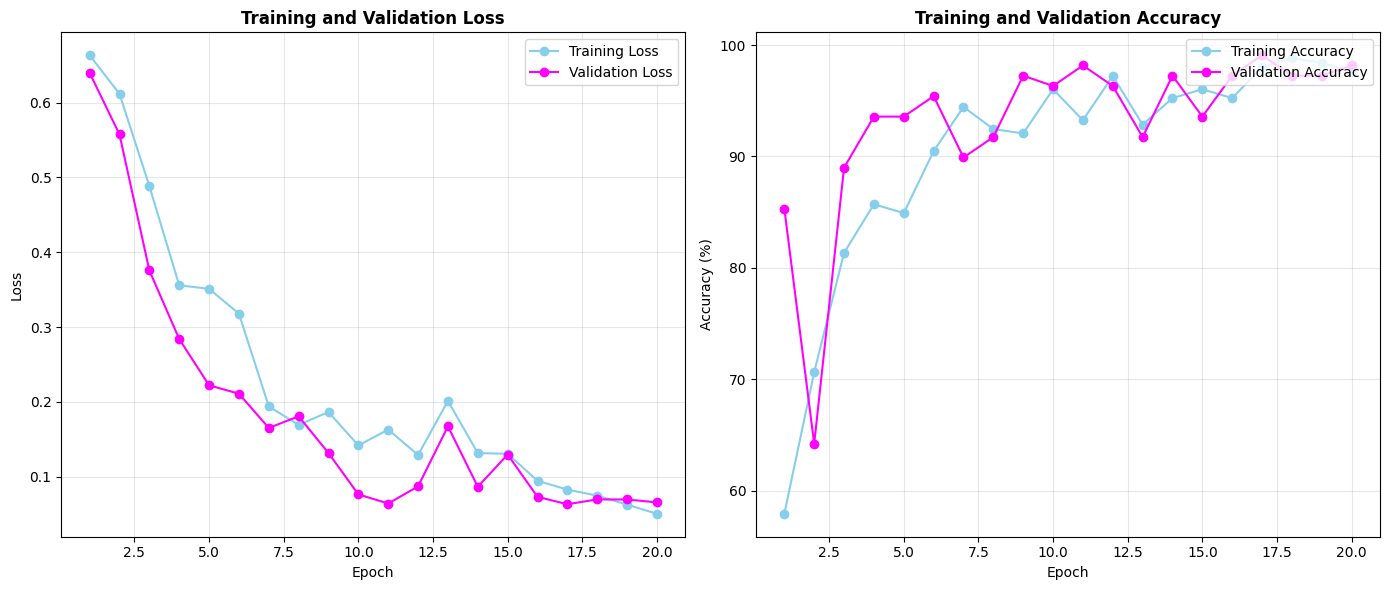

In [21]:
# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss",color='skyblue', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label="Validation Loss", color='magenta', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss", fontweight='bold')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)


# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", color='skyblue', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Validation Accuracy", color='magenta', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy", fontweight='bold')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

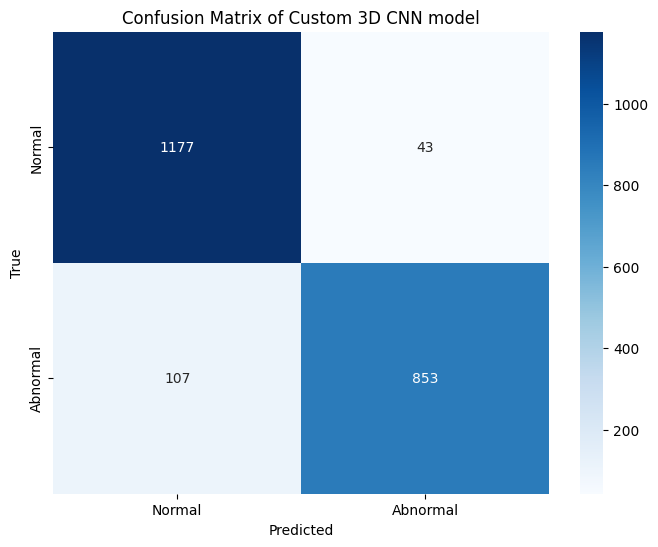

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(data_labels, data_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix of Custom 3D CNN model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
accuracy = accuracy_score(data_labels, data_predictions)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn) # Sensitivity
specificity = tn / (tn + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Classification report
report = classification_report(data_labels, data_predictions, target_names=['Normal', 'Abnormal'])
print("\nClassification Report:\n", report)

Accuracy: 0.93
Precision: 0.95
Recall (Sensitivity): 0.89
Specificity: 0.96
F1 Score: 0.92

Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.96      0.94      1220
    Abnormal       0.95      0.89      0.92       960

    accuracy                           0.93      2180
   macro avg       0.93      0.93      0.93      2180
weighted avg       0.93      0.93      0.93      2180



## Adding Spatial Attention

In [24]:
# Define a Spatial Attention Block
class SpatialAttention(nn.Module):
    def __init__(self, input_channels):
        super(SpatialAttention, self).__init__()
        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(input_channels, input_channels // 8)
        self.fc2 = nn.Linear(input_channels // 8, input_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, depth, height, width = x.size()
        pooled = self.global_avg_pool(x).view(batch, channels)
        attention = self.fc1(pooled)
        attention = F.relu(attention)
        attention = self.fc2(attention)
        attention = self.sigmoid(attention).view(batch, channels, 1, 1, 1)

        # Element-wise scaling
        return x * attention

# Add Attention to CNN3D Model
class CNN3DWithAttention(nn.Module):
    def __init__(self):
        super(CNN3DWithAttention, self).__init__()

        self.conv1 = nn.Conv3d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.att1 = SpatialAttention(32)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.att2 = SpatialAttention(64)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)

        self.pool1 = nn.MaxPool3d((2, 2, 2))
        self.pool2 = nn.MaxPool3d((1, 2, 2))
        self.dropout = nn.Dropout(0.5)

        self.fc1 = None
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Convolution layer 1 with attention
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.att1(x)

        # Convolution layer 2 with attention
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.att2(x)

        # Convolution layer 3
        x = self.pool2(F.relu(self.conv3(x)))

        # Set fc1 dynamically during forward pass
        if self.fc1 is None:
            flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(flattened_size, 128).to(x.device)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

# Initialise updated model
model_with_attention = CNN3DWithAttention().to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_with_attention.parameters(), lr=0.001, weight_decay=0.01)

In [25]:
# Initialise updated model with attention
model = model_with_attention
model.to(device)

# Training loop
num_epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
data_labels = []
data_predictions = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    # Training phase
    for clips, labels in train_loader:
        clips, labels = clips.to(device), labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(clips).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and store train loss and accuracy for epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for clips, labels in test_loader:
            clips, labels = clips.to(device), labels.to(device).float()
            outputs = model(clips).view(-1)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store the actual labels and predicted labels (confusion matrix)
            data_labels.extend(labels.cpu().numpy())
            data_predictions.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    test_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    test_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), '3dcnn_with_attention.pth')

Epoch [1/20], Train Loss: 0.6794, Train Accuracy: 52.38%, Validation Loss: 0.6854, Validation Accuracy: 55.96%
Epoch [2/20], Train Loss: 0.6587, Train Accuracy: 61.51%, Validation Loss: 0.5847, Validation Accuracy: 62.39%
Epoch [3/20], Train Loss: 0.6104, Train Accuracy: 69.44%, Validation Loss: 0.5230, Validation Accuracy: 71.56%
Epoch [4/20], Train Loss: 0.4972, Train Accuracy: 81.35%, Validation Loss: 0.3473, Validation Accuracy: 88.07%
Epoch [5/20], Train Loss: 0.4043, Train Accuracy: 83.73%, Validation Loss: 0.3059, Validation Accuracy: 89.91%
Epoch [6/20], Train Loss: 0.3141, Train Accuracy: 90.48%, Validation Loss: 0.2932, Validation Accuracy: 90.83%
Epoch [7/20], Train Loss: 0.2864, Train Accuracy: 90.08%, Validation Loss: 0.2735, Validation Accuracy: 91.74%
Epoch [8/20], Train Loss: 0.3015, Train Accuracy: 88.10%, Validation Loss: 0.2256, Validation Accuracy: 91.74%
Epoch [9/20], Train Loss: 0.2455, Train Accuracy: 91.67%, Validation Loss: 0.2172, Validation Accuracy: 92.66%
E

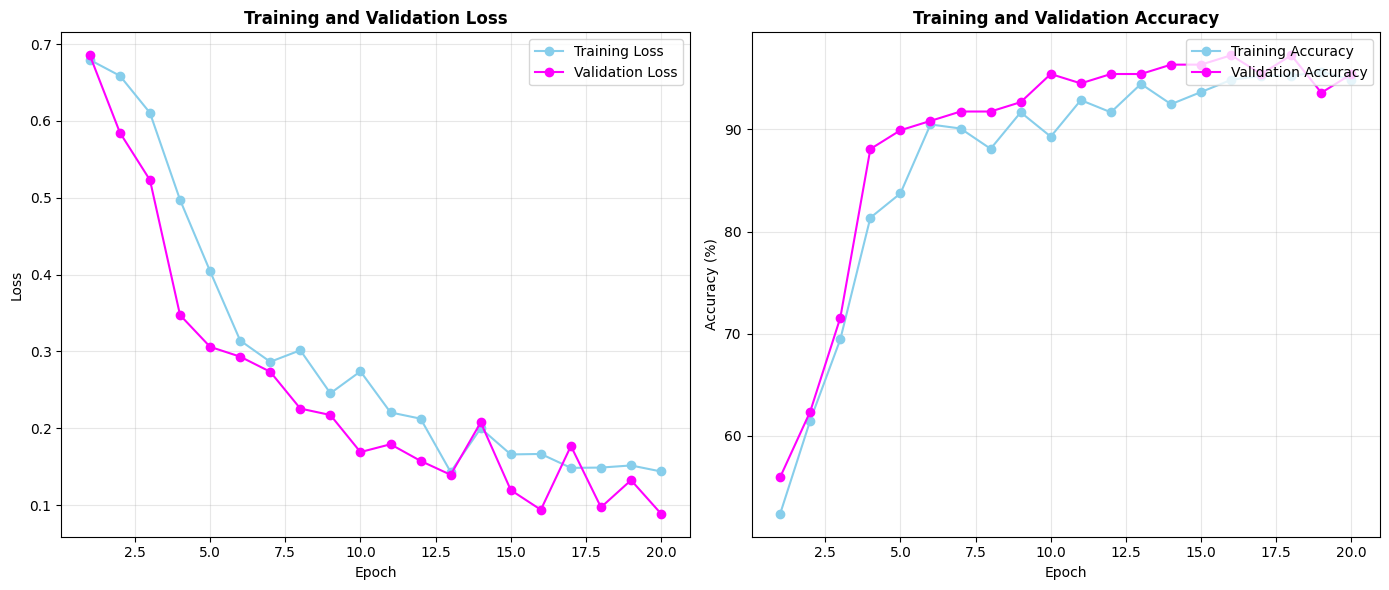

In [26]:
# Plot training and validation loss
plt.figure(figsize=(14, 6))

# Subplot for loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color='skyblue', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label="Validation Loss", color='magenta', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss", fontweight='bold')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)


# Subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", color='skyblue', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Validation Accuracy", color='magenta', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy", fontweight='bold')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)


# Adjust layout for better spacing
plt.tight_layout()
plt.show()


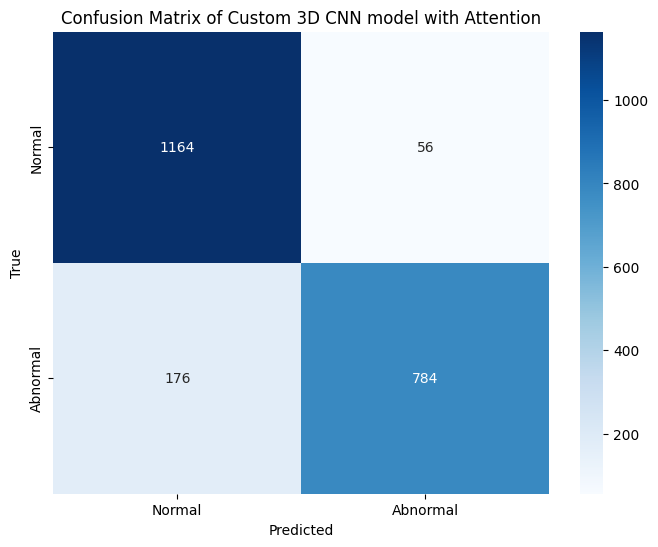

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(data_labels, data_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title('Confusion Matrix of Custom 3D CNN model with Attention')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
accuracy = accuracy_score(data_labels, data_predictions)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn) # Sensitivity
specificity = tn / (tn + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# Classification report
report = classification_report(data_labels, data_predictions, target_names=['Normal', 'Abnormal'])
print("\nClassification Report:\n", report)

Accuracy: 0.89
Precision: 0.93
Recall (Sensitivity): 0.82
Specificity: 0.95
F1 Score: 0.87

Classification Report:
               precision    recall  f1-score   support

      Normal       0.87      0.95      0.91      1220
    Abnormal       0.93      0.82      0.87       960

    accuracy                           0.89      2180
   macro avg       0.90      0.89      0.89      2180
weighted avg       0.90      0.89      0.89      2180



In [29]:
# adds too many parameters to an already specialised model ?